In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
import itertools
import pickle
plt.style.use('fivethirtyeight') # For plots
import os
#Author: Vatsala

In [2]:
#import fbprophet
#fbprophet.__version__

In [3]:
#import utils

In [4]:
plot_file_path ="../prophetForecastPlots/Plot"
plot_data_path ="../plotData/"

#### Specify Plot ID

In [5]:
plotId = "1"

#### Create directory for storing facebook prophet forecasts

In [6]:
# define the name of the directory to be created for the png outputs

path_image = plot_file_path+str(plotId)

try:
    if not os.path.exists(path_image):     
         os.mkdir(path_image)
except OSError:
    print ("Creation of the directory %s failed" % path_image)
else:
    print ("Successfully created the directory %s " % path_image)

Successfully created the directory ../prophetForecastPlots/Plot1 


In [7]:
#****** Running Forecast for Plot 1 *******  Note: Data has been QC-ed

#read Plot 1 data
data = read_excel('../plotData/plotData_'+plotId+'.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [8]:
print(data.head(10))
data.dtypes

                     QC  Plot_ID  DailyRep treatment       Date   pv      ghg  \
DateTime                                                                        
2019-03-26 17:26:00   0        1         4        F0 2019-03-26  ***  N2O_dry   
2019-03-26 21:49:00   0        1         5        F0 2019-03-26  ***  N2O_dry   
2019-03-27 06:28:00   0        1         1        F0 2019-03-27  ***  N2O_dry   
2019-03-28 20:34:00   0        1         2        F0 2019-03-28    *  N2O_dry   
2019-03-30 02:43:00   0        1         0        F0 2019-03-30  ***  N2O_dry   
2019-03-30 15:27:00   0        1         2        F0 2019-03-30  ***  N2O_dry   
2019-03-30 19:51:00   0        1         3        F0 2019-03-30   **  N2O_dry   
2019-03-31 00:17:00   0        1         0        F0 2019-03-31  ***  N2O_dry   
2019-03-31 04:43:00   0        1         1        F0 2019-03-31  ***  N2O_dry   
2019-03-31 13:32:00   0        1         3        F0 2019-03-31  ***  N2O_dry   

                    unit   

QC                     int64
Plot_ID                int64
DailyRep               int64
treatment             object
Date          datetime64[ns]
pv                    object
ghg                   object
unit                  object
flux                 float64
r2                   float64
nrmse                float64
podpu                float64
epoch_time            object
dtype: object

In [9]:
#This dataframe will be used for running in the Prophet model
#Extract only datetime and flux from the series

dataframe = DataFrame()
dataframe['Flux']  = data['flux']
dataframe['ghg']   = data['ghg']
dataframe

,Flux,ghg
DateTime,,
2019-03-26 17:26:00,-144.0262,N2O_dry
2019-03-26 21:49:00,-102.3469,N2O_dry
2019-03-27 06:28:00,-93.0909,N2O_dry
2019-03-28 20:34:00,63.8219,N2O_dry
2019-03-30 02:43:00,-157.9453,N2O_dry
...,...,...
2019-06-29 04:46:00,930.5471,CO2_dry
2019-06-29 13:22:00,412.6364,CO2_dry
2019-06-29 17:41:00,540.0715,CO2_dry


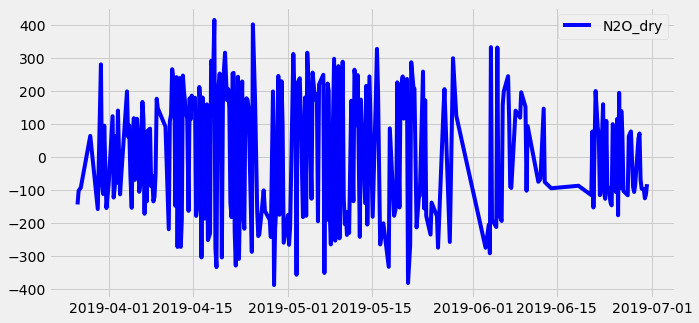

In [10]:
# Plot by each different gas
#fig, axs = plt.subplots(3, figsize=(15,15))
fig, axs = plt.subplots(1, figsize=(10,5))

df_N2Odry = dataframe[dataframe['ghg'] == 'N2O_dry']

axs.plot(df_N2Odry['Flux'], color='blue')

axs.legend(['N2O_dry'])

plt.show()

### Feature Engineering

In [11]:
#create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.
#Feature Engineering  - feature used to visualise the data
def create_features(df, label=None):
    '''Create time series features from date time index'''
    df = df.copy()
    df['date']        = df.index #df['DateTime']  #.index
    df['hour']        = df['date'].dt.hour
    df['dayofmonth']  = df['date'].dt.day
    df['month']       = df['date'].dt.month
    df['year']        = df['date'].dt.year
    df['weekofyear']  = df['date'].dt.weekofyear
    df['dayofweek']   = df['date'].dt.dayofweek
    df['dayname']     = df['date'].dt.day_name() 
   
    X = df[['year', 'month', 'dayofmonth', 'weekofyear', 'hour', 'dayofweek', 'dayname']]  #features should be a matrix
    
    if label:
        y = df[label]   #target
        return X,y
    return X

In [13]:
X, y            = create_features(df_N2Odry, 'Flux')    #the target is the flux in this case; the features = X (as shown above)
features_target = pd.concat([X, y], axis=1)  #concatenate the features and the target
features_target.head()

,year,month,dayofmonth,weekofyear,hour,dayofweek,dayname,Flux
DateTime,,,,,,,,
2019-03-26 17:26:00,2019,3,26,13,17,1,Tuesday,-144.0262
2019-03-26 21:49:00,2019,3,26,13,21,1,Tuesday,-102.3469
2019-03-27 06:28:00,2019,3,27,13,6,2,Wednesday,-93.0909
2019-03-28 20:34:00,2019,3,28,13,20,3,Thursday,63.8219
2019-03-30 02:43:00,2019,3,30,13,2,5,Saturday,-157.9453


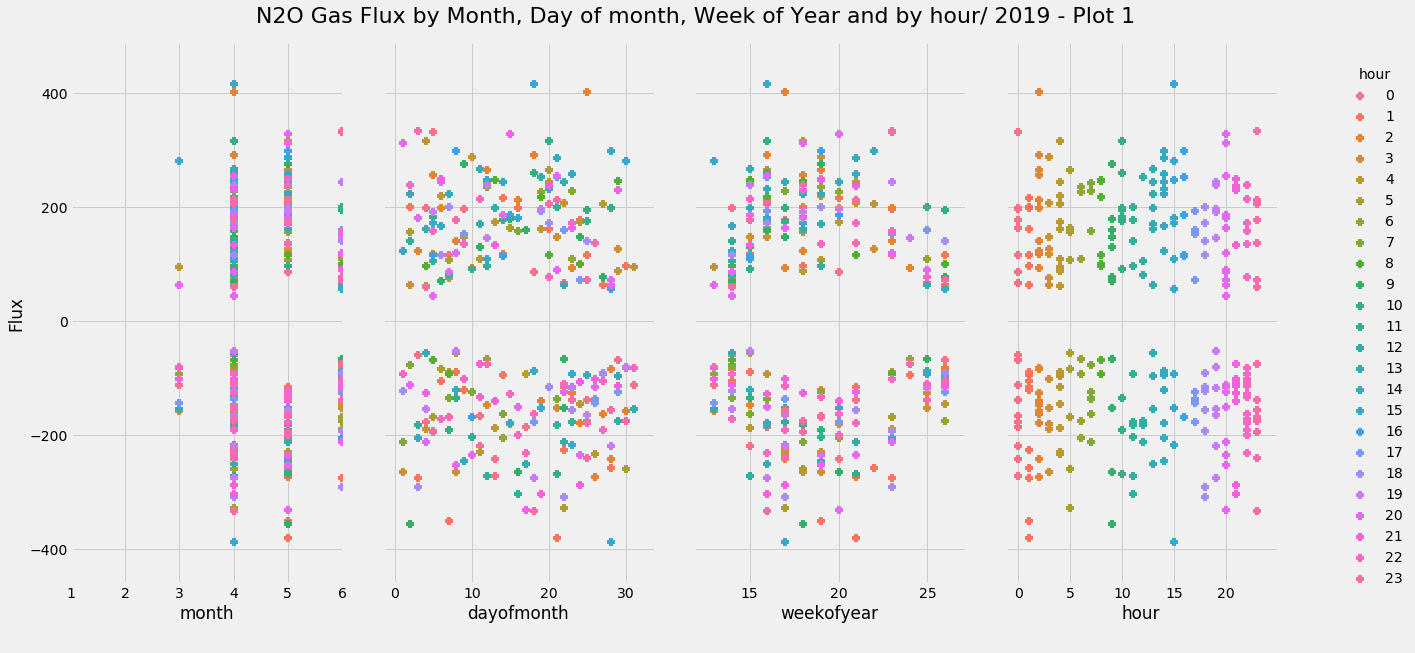

In [14]:
#plt.figure(figsize=(30,20))
sns_plot = sns.pairplot(features_target.dropna(), diag_kind="kde", markers="+", hue='hour', 
                  x_vars=['month', 'dayofmonth','weekofyear','hour'],
                  y_vars='Flux',
                      
                  plot_kws=dict(s=70, edgecolor="b", linewidth=4),
                  diag_kws=dict(shade=True))

#year_value = features_target['year'].iloc[0]      

plt.suptitle('N2O Gas Flux by Month, Day of month, Week of Year and by hour/ '+str(features_target['year'].iloc[0])+' - Plot '+plotId, fontsize=22, y=1.02)

sns_plot.fig.set_figwidth(20)
sns_plot.fig.set_figheight(10)

#For plotting month
sns_plot.axes[0][0].set_xlim(1,6)
sns_plot.axes[0][0].set_ylim(None, None)

##For plotting year
#df1_year=features_target.dropna(axis=0)
## Get hold of the 'Axes' objects
#sns_plot.axes[0][0].set_xticks(df1_year['year'])
#sns_plot.axes[0][0].set_ylim(None, None)

#Save boxplot as a file
#output file name
plot_file_name="../prophetForecastPlots/Plot"+plotId+"/CO2_gasflux_Plot"+plotId+"_features.png" 
# save as png
sns_plot.savefig(plot_file_name)

plt.show()

### Do Resampling of the gas flux - every 30 min

In [15]:
df_N2Odry

,Flux,ghg
DateTime,,
2019-03-26 17:26:00,-144.0262,N2O_dry
2019-03-26 21:49:00,-102.3469,N2O_dry
2019-03-27 06:28:00,-93.0909,N2O_dry
2019-03-28 20:34:00,63.8219,N2O_dry
2019-03-30 02:43:00,-157.9453,N2O_dry
...,...,...
2019-06-29 04:46:00,-96.2937,N2O_dry
2019-06-29 13:22:00,-97.1944,N2O_dry
2019-06-29 17:41:00,-125.4368,N2O_dry


In [16]:
df_N2Odry1 = df_N2Odry.drop('ghg', axis=1)
df_N2Odry1.to_csv('n2odry.csv')
df_N2Odry1

,Flux
DateTime,
2019-03-26 17:26:00,-144.0262
2019-03-26 21:49:00,-102.3469
2019-03-27 06:28:00,-93.0909
2019-03-28 20:34:00,63.8219
2019-03-30 02:43:00,-157.9453
...,...
2019-06-29 04:46:00,-96.2937
2019-06-29 13:22:00,-97.1944
2019-06-29 17:41:00,-125.4368


### Rounding the data to 30 min
Normalise the timestamp to every 30 min in the plot data

In [17]:
plot_dataframe = DataFrame()

plot_dataframe['Flux']      = df_N2Odry1['Flux']
plot_dataframe['Timestamp'] = df_N2Odry1.index

#round the timestamp value to nearest quarter
#plot1_dataframe['TIMESTAMP_1_rounded'] = plot1_dataframe['Timestamp'].dt.round('15min')

#round the timestamp value to nearest half hour
plot_dataframe['DateTime'] = plot_dataframe['Timestamp'].dt.round('30min')

#Drop the column Timestamp - the rounded Timestamp value will be used for plotting
plot_dataframe.drop('Timestamp', axis=1, inplace=True)

#Create new index
plot_dataframe.reset_index(drop=True, inplace=True)
plot_dataframe.set_index('DateTime', drop=True, append=False, inplace=True, verify_integrity=False)

plot_dataframe

,Flux
DateTime,
2019-03-26 17:30:00,-144.0262
2019-03-26 22:00:00,-102.3469
2019-03-27 06:30:00,-93.0909
2019-03-28 20:30:00,63.8219
2019-03-30 02:30:00,-157.9453
...,...
2019-06-29 05:00:00,-96.2937
2019-06-29 13:30:00,-97.1944
2019-06-29 17:30:00,-125.4368


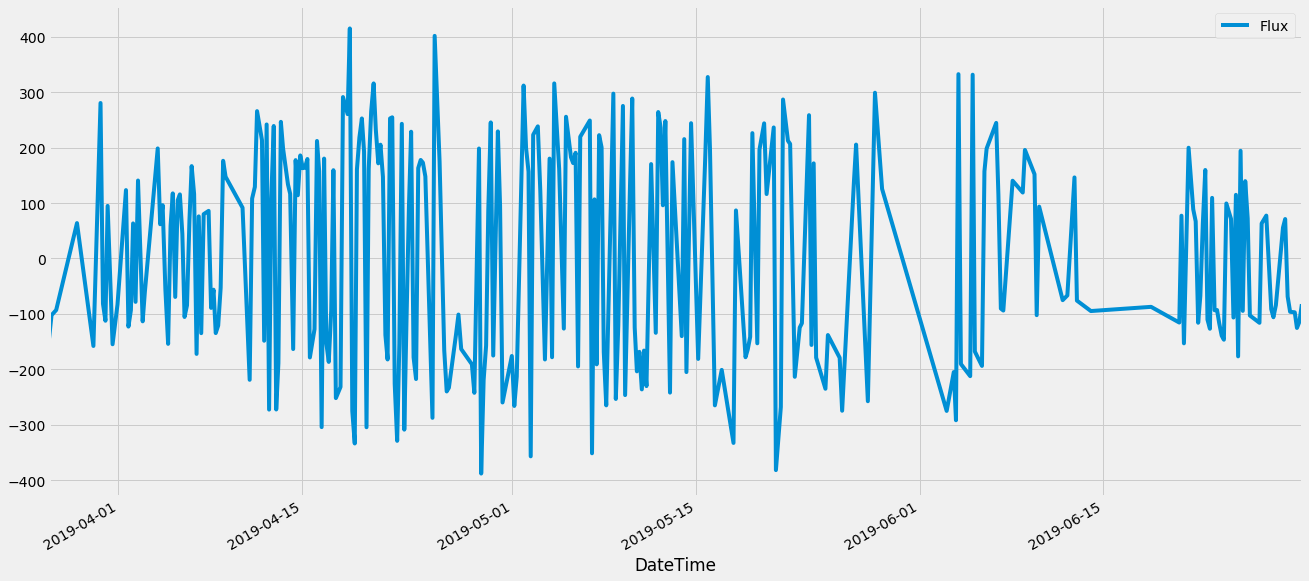

In [18]:
#daily_mean_flux1 = daily_mean_flux.dropna(axis=0)
plot_dataframe.plot(figsize=(20, 10))
plt.show()

### Resample the dataset and repeat the forecasting procedure

In [19]:
resample        = plot_dataframe.resample('30min')
daily_mean_flux = resample.mean()

#daily_mean_flux = daily_mean_flux.dropna()
print(daily_mean_flux)
#daily_mean_flux.plot(figsize=(20, 10))
#plt.show()

                         Flux
DateTime                     
2019-03-26 17:30:00 -144.0262
2019-03-26 18:00:00       NaN
2019-03-26 18:30:00       NaN
2019-03-26 19:00:00       NaN
2019-03-26 19:30:00       NaN
...                       ...
2019-06-30 00:30:00       NaN
2019-06-30 01:00:00       NaN
2019-06-30 01:30:00       NaN
2019-06-30 02:00:00       NaN
2019-06-30 02:30:00  -82.5197

[4579 rows x 1 columns]


### Remove missing values - later interpolate to replace the missing values

In [20]:
daily_mean_flux1 = daily_mean_flux.dropna(axis=0)

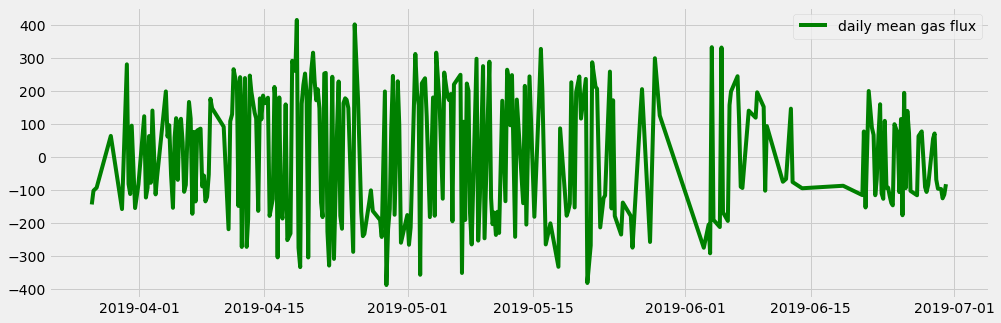

In [21]:
#daily_mean_flux.plot(figsize=(20, 10))
#plt.show()

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(daily_mean_flux1.index, daily_mean_flux1['Flux'], color='g', label="daily mean gas flux")
ax.legend()

### Split the data into training and test set

In [22]:
split_date = '31-May-2019'

dataf = daily_mean_flux1 #.dropna(axis=0)  #HERE USE DATAFRAME not features_target(this is for visualising)

dataframe_train_N2Odry = dataf.loc[dataf.index <= split_date].copy()
dataframe_test_N2Odry  = dataf.loc[dataf.index > split_date].copy()

print(dataframe_test_N2Odry.head(10))
print(dataframe_train_N2Odry.head(10))

                         Flux
DateTime                     
2019-06-03 01:30:00 -275.2034
2019-06-03 14:30:00 -205.0562
2019-06-03 18:30:00 -292.0040
2019-06-03 23:00:00  332.6790
2019-06-04 03:30:00 -190.4778
2019-06-04 20:30:00 -212.4400
2019-06-05 01:00:00  331.6722
2019-06-05 05:00:00 -167.9997
2019-06-05 18:00:00 -193.9698
2019-06-05 22:30:00  157.2500
                         Flux
DateTime                     
2019-03-26 17:30:00 -144.0262
2019-03-26 22:00:00 -102.3469
2019-03-27 06:30:00  -93.0909
2019-03-28 20:30:00   63.8219
2019-03-30 02:30:00 -157.9453
2019-03-30 15:30:00  280.6187
2019-03-30 20:00:00  -81.8122
2019-03-31 00:30:00 -112.4232
2019-03-31 04:30:00   94.8818
2019-03-31 13:30:00 -154.8489


### Use Prophet Model to predict the gas flux

In [61]:
df = dataframe_train_N2Odry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df['cap']   = 2000
df['floor'] = -2000

In [58]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())  #take different combinations of the values e.g. 0.005, 0.8, 0.1, multiplicative, linear, 1
    params     = []
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m6 = Prophet(**param_dict)
    #m.add_country_holidays(country_name='US')
    m6.fit(history_df)    
    df_cv = cross_validation(m6, initial='42 days', period='7 days', horizon = '14 days') #parallel="processes" Not available yet in current release    
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 2, 5, 10.0],
                #'n_changepoints': [25,75,100],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic']
                #'yearly_seasonality': [5, 10, 20]
                #'daily_seasonality' : [1, 3, 5]
             }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []
#rmses   = []  # Store the RMSEs for each params here

params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df, metrics, param_dict)
    results.append(cv_df)
    #rmses.append(cv_df['rmse'].values[0])
    
results_df_n2o_resamp_30min = pd.concat(results).reset_index(drop=True)
best_param = results_df_n2o_resamp_30min.loc[results_df_n2o_resamp_30min['mape'] == min(results_df_n2o_resamp_30min['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')

results_df_n2o_resamp_30min

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:30:00 and 2019-05-15 03:30:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:30:00 and 2019-05-15 03:30:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:30:00 and 2019-05-15 03:30:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:30:00 and 2019-05-15 03:30:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-08 03:30:00 and 2019-


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_prior_scale': 2.0, 'seasonality_mode': 'multiplicative', 'growth': 'logistic'}


,horizon,rmse,mape,params
0,6 days 22:39:39.661016,217.233,1.00434,"{'changepoint_prior_scale': 0.001, 'changepoin..."
1,6 days 22:39:39.661016,440.253,1.9153,"{'changepoint_prior_scale': 0.001, 'changepoin..."
2,6 days 22:39:39.661016,222.532,1.04824,"{'changepoint_prior_scale': 0.001, 'changepoin..."
3,6 days 22:39:39.661016,443.529,1.92234,"{'changepoint_prior_scale': 0.001, 'changepoin..."
4,6 days 22:39:39.661016,231.202,1.07257,"{'changepoint_prior_scale': 0.001, 'changepoin..."
...,...,...,...,...
155,6 days 22:39:39.661016,230.617,1.04892,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
156,6 days 22:39:39.661016,351.045,1.50552,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
157,6 days 22:39:39.661016,225.123,1.00247,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
158,6 days 22:39:39.661016,225.044,1.05679,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [59]:
#Run best parameter configuration
results_df_n2o_resamp_30min.to_csv("HyperParameterTuning_N2O_model_resampling_30min")

best_param = results_df_n2o_resamp_30min.loc[results_df_n2o_resamp_30min['mape'] == min(results_df_n2o_resamp_30min['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_prior_scale': 2.0, 'seasonality_mode': 'multiplicative', 'growth': 'logistic'}


In [60]:
mT_v4 = Prophet(
    changepoint_prior_scale= 0.5,
    changepoint_range= 0.9,
    #n_changepoints= 125,
    seasonality_prior_scale= 2.0,
    seasonality_mode = 'multiplicative',
    growth = 'logistic' 
)

mT_v4.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


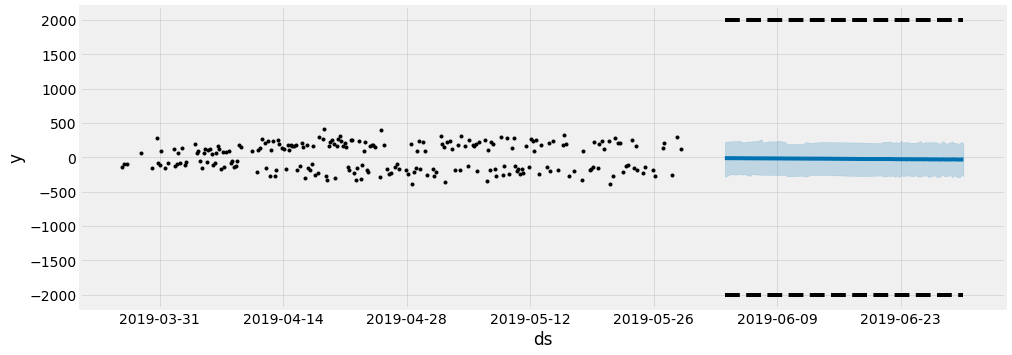

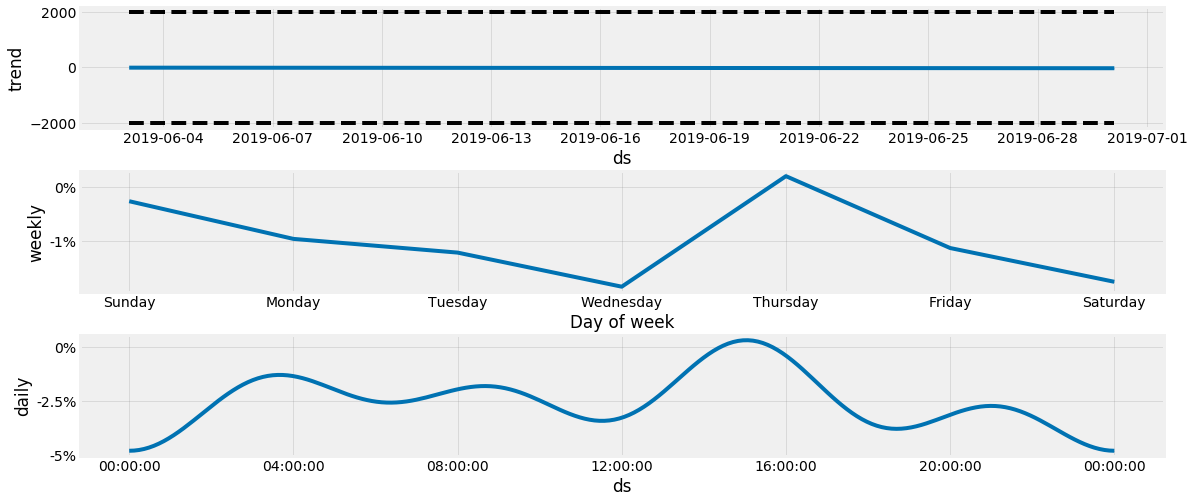

In [62]:
df1 = dataframe_test_N2Odry.reset_index().rename(columns={'DateTime': 'ds'})
#df = dataframe_train_N2Odry.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})              
df1['cap']   = 2000
df1['floor'] = -2000

forecast_mT_v4 = mT_v4.predict(df1)

fig21          = mT_v4.plot(forecast_mT_v4)
fig22          = mT_v4.plot_components(forecast_mT_v4)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Check the performance of the tuned model

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
mape = mean_absolute_percentage_error(dataframe_test_N2Odry['Flux'],forecast_mT_v4['yhat'])
print("MAPE",round(mape,4))

MAPE 96.4163


### Compare Forecast vs Actual using resampled data Model

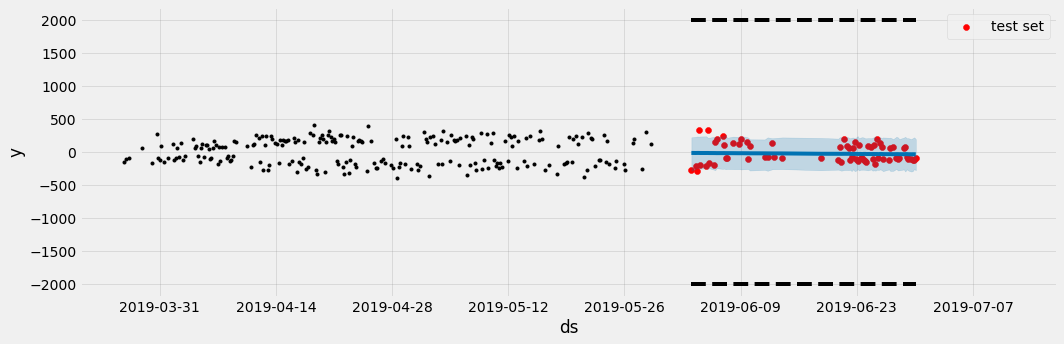

In [65]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_N2Odry.index, dataframe_test_N2Odry['Flux'], color='r', label="test set")
ax.legend()
fig = mT_v4.plot(forecast_mT_v4, ax=ax)

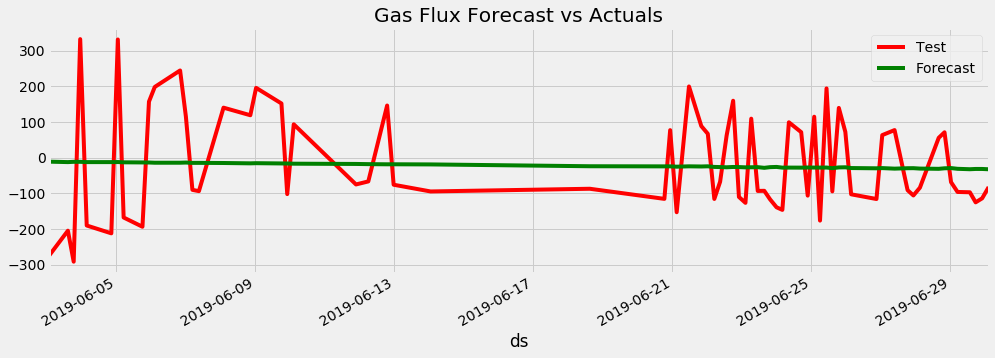

In [66]:
df1=dataframe_test_N2Odry.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_mT_v4.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Interpolate to replace missing values

In [44]:
daily_mean_flux.to_csv('n2o_resample30min.csv')  #check the values prior to doing interpolation

In [45]:
daily_mean_flux2 = daily_mean_flux.interpolate(method='linear')
daily_mean_flux2.to_csv('daily_mean_flux2_N2O_30min_interpolate.csv')
daily_mean_flux2

,Flux
DateTime,
2019-03-26 17:30:00,-144.026200
2019-03-26 18:00:00,-139.395167
2019-03-26 18:30:00,-134.764133
2019-03-26 19:00:00,-130.133100
2019-03-26 19:30:00,-125.502067
...,...
2019-06-30 00:30:00,-96.573878
2019-06-30 01:00:00,-93.060333
2019-06-30 01:30:00,-89.546789


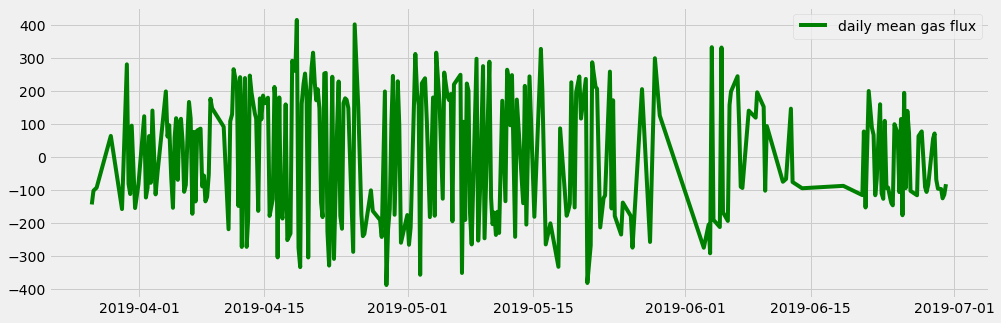

In [46]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(daily_mean_flux2.index, daily_mean_flux2['Flux'], color='g', label="daily mean gas flux")
ax.legend()

### Split the data into training and test set

In [49]:
#Train Test - split data
split_date = '31-May-2019'

dataf = daily_mean_flux2 #.dropna(axis=0)  #HERE USE DATAFRAME not features_target(this is for visualising)

dataframe_train_N2Odry2 = dataf.loc[dataf.index <= split_date].copy()
dataframe_test_N2Odry2  = dataf.loc[dataf.index > split_date].copy()

print(dataframe_test_N2Odry2.head(10))
print(dataframe_train_N2Odry2.head(10))

                          Flux
DateTime                      
2019-05-31 00:30:00 -27.264282
2019-05-31 01:00:00 -28.962495
2019-05-31 01:30:00 -30.660708
2019-05-31 02:00:00 -32.358922
2019-05-31 02:30:00 -34.057135
2019-05-31 03:00:00 -35.755348
2019-05-31 03:30:00 -37.453561
2019-05-31 04:00:00 -39.151774
2019-05-31 04:30:00 -40.849987
2019-05-31 05:00:00 -42.548200
                           Flux
DateTime                       
2019-03-26 17:30:00 -144.026200
2019-03-26 18:00:00 -139.395167
2019-03-26 18:30:00 -134.764133
2019-03-26 19:00:00 -130.133100
2019-03-26 19:30:00 -125.502067
2019-03-26 20:00:00 -120.871033
2019-03-26 20:30:00 -116.240000
2019-03-26 21:00:00 -111.608967
2019-03-26 21:30:00 -106.977933
2019-03-26 22:00:00 -102.346900


### Use Prophet Model to predict the gas flux

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


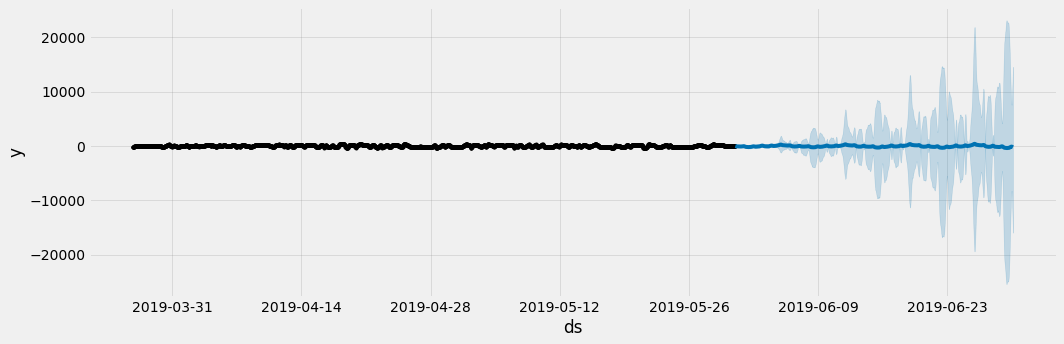

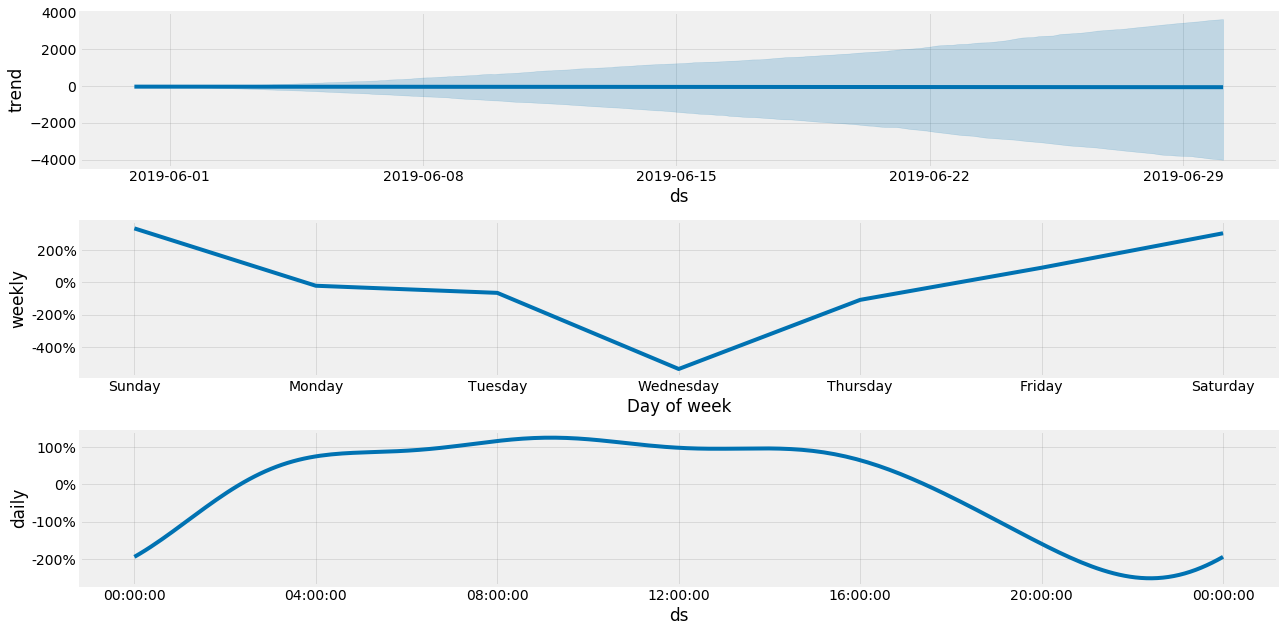

In [50]:
n2o_model_resample_interpola = Prophet(
                     #changepoint_prior_scale=0.4,
                     #seasonality_prior_scale=0.01,
                     #n_changepoints= 125,
                     #interval_width=0.95)

                     changepoint_prior_scale= 5, #0.05
                     changepoint_range= 0.8,
                     #n_changepoints= 125,
                     seasonality_prior_scale= 1, #0.1,
                     seasonality_mode = 'multiplicative',
                     growth = 'linear')
    
    #changepoint_prior_scale= 0.01,
    #changepoint_range= 0.8,
    ##n_changepoints= 125,
    #seasonality_prior_scale= 0.1,
    #seasonality_mode = 'multiplicative',
    #growth = 'linear' )

    
n2o_model_resample_interpola.fit(dataframe_train_N2Odry2.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'}))

forecast_resampled_interpolamodel_n2o = n2o_model_resample_interpola.predict(df=dataframe_test_N2Odry2.reset_index().rename(columns={'DateTime': 'ds'}))

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = n2o_model_resample_interpola.plot(forecast_resampled_interpolamodel_n2o,ax=ax)
plt.show()

# Plot the components of the model
fig1 = n2o_model_resample_interpola.plot_components(forecast_resampled_interpolamodel_n2o)
fig1.set_figwidth(20)

### Check the performance of the tuned model mT_v1

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
mape = mean_absolute_percentage_error(dataframe_test_N2Odry2['Flux'],forecast_resampled_interpolamodel_n2o['yhat'])
print("MAPE",round(mape,4))

MAPE 260.0377


### Compare Forecast vs Actual using resampled data Model¶

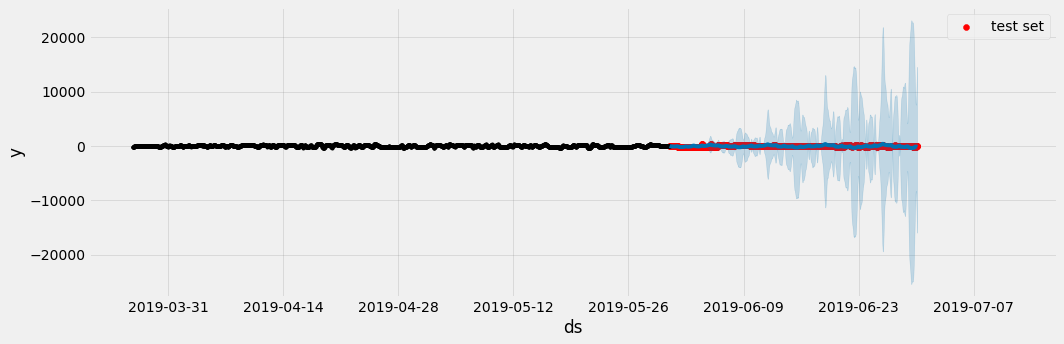

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(dataframe_test_N2Odry2.index, dataframe_test_N2Odry2['Flux'], color='r', label="test set")
ax.legend()
fig = n2o_model_resample_interpola.plot(forecast_resampled_interpolamodel_n2o, ax=ax)

### Compare the gas flux in test set and in forecasted set

In [55]:
pd.plotting.register_matplotlib_converters()

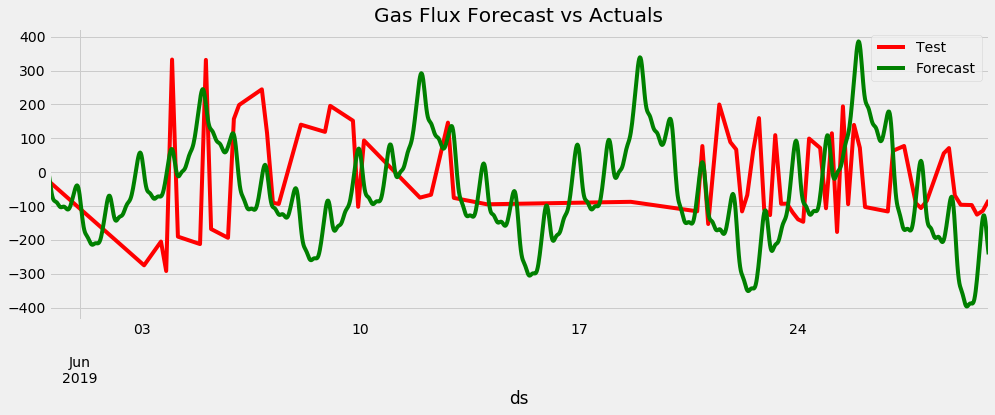

In [56]:
df1=dataframe_test_N2Odry2.reset_index().rename(columns={'DateTime': 'ds'})

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='Flux', color='red', label='Test', ax=ax)
forecast_resampled_interpolamodel_n2o.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Read the met data - the regressors to be added

In [200]:
#allMetData_filtered = read_excel('../plotData/allMetData_filtered.xlsx', sheet_name='Sheet1') 
#allMetData_filtered

In [201]:
#Read met data - filtered and normalised
metData_AirParams = read_excel('../plotData/MetData_AirParams.xlsx', sheet_name='Sheet1') 



metData_AirParams['ds'] = metData_AirParams['TIMESTAMP_1_rounded']

metData_AirParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_AirParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
metData_AirParams

,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,Pa_1_1_1,P_1_1_1
ds,,,,,,
2019-03-26 17:30:00,1.185082,2.853651,11.850,54.435,101.8,0.0
2019-03-27 08:30:00,3.637683,5.828328,7.262,78.595,102.1,0.0
2019-03-27 09:00:00,10.508773,12.427950,7.648,77.565,102.1,0.0
2019-03-27 09:30:00,20.978545,23.094235,8.465,75.635,102.1,0.0
2019-03-27 10:00:00,33.931725,36.153975,9.505,71.990,102.1,0.0
...,...,...,...,...,...,...
2019-06-29 18:30:00,40.378545,18.857910,28.225,51.725,99.6,0.0
2019-06-29 19:00:00,27.381235,12.488385,26.360,57.805,99.6,0.0
2019-06-29 19:30:00,19.718745,9.545013,25.520,62.120,99.6,0.0


### Merge the metdata together with the (gas flux) plot data

In [202]:
#metData_AirParams

#Merge dataframes- based on index
#plot1_metdata_slice11 = df1.reset_index().merge(metData_AirParams, left_index=True, right_index=True, how='inner').set_index('ds')

#testt = df1.merge(metData_AirParams, left_index=True, right_index=True, how='inner')

#a.reset_index().merge(b, how="left").set_index('index')

#plot1_metdata_slice11.to_excel(plot_data_path+'Plot'+plotId+'_GasFlux_MetData_AirParams1.xlsx')

#testt

### Interpolation to replace missing values

In [203]:
temp = metData_AirParams.interpolate(method='linear')

In [205]:
df1

,y
ds,
2019-03-26 16:00:00,-466.8398
2019-03-26 20:00:00,91.8985
2019-03-27 06:00:00,308.7397
2019-03-28 20:00:00,-129.9216
2019-03-30 02:00:00,404.0616
...,...
2019-05-26 22:00:00,557.4424
2019-05-27 04:00:00,547.5419
2019-05-28 00:00:00,589.3561


In [206]:
merged_df = df1.merge(metData_AirParams, left_index=True, right_index=True, how='inner')

merged_df

,y,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,Pa_1_1_1,P_1_1_1
ds,,,,,,,
2019-03-30 14:00:00,-1701.9439,44.172050,59.169415,15.3500,59.400,100.6,0.000
2019-03-31 12:00:00,-1389.1798,24.702140,29.694365,9.2200,75.685,101.1,0.000
2019-04-01 14:00:00,-1447.0002,26.636625,55.907075,12.9550,53.860,100.4,0.000
2019-04-04 12:00:00,-693.3395,19.346235,26.070820,5.2835,88.950,97.7,1.386
2019-04-05 08:00:00,-380.7328,3.089714,8.006914,6.8570,86.500,98.6,0.000
...,...,...,...,...,...,...,...
2019-05-21 14:00:00,-782.4440,39.039860,41.033055,18.1100,50.140,100.5,0.000
2019-05-22 12:00:00,-744.9078,36.387095,36.542385,16.6900,50.285,100.6,0.000
2019-05-23 14:00:00,-994.4530,34.872310,35.462745,20.2950,40.120,100.1,0.000


### Add Regressors to the model

#### Split the merged dataset into training and test set  on Resampled Dataset

In [152]:
#Train Test - split data
split_date = '30-April-2019'

#dataf = daily_mean_flux

mergeddf_train_CO2dry = merged_df.loc[merged_df.index <= split_date].copy()
mergeddf_test_CO2dry  = merged_df.loc[merged_df.index > split_date].copy()


#print(mergeddf_test_CO2dry.head(10))
#print(mergeddf_train_CO2dry.head(10))

In [ ]:
mergeddf_test_CO2dry.reset_index(inplace=True)
#mergeddf_test_CO2dry

In [167]:
mergeddf_train_CO2dry.reset_index(inplace=True)
#mergeddf_train_CO2dry

In [168]:
pro_regressor = Prophet()  #add tuning parameters later
pro_regressor.add_regressor('G_1_1_1')
pro_regressor.add_regressor('G_2_1_1')
pro_regressor.add_regressor('Ta_1_1_1')
pro_regressor.add_regressor('RH_1_1_1')
pro_regressor.add_regressor('Pa_1_1_1')
pro_regressor.add_regressor('P_1_1_1')

#Fitting the data
pro_regressor.fit(mergeddf_train_CO2dry)

future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_data = pro_regressor.predict(mergeddf_test_CO2dry)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


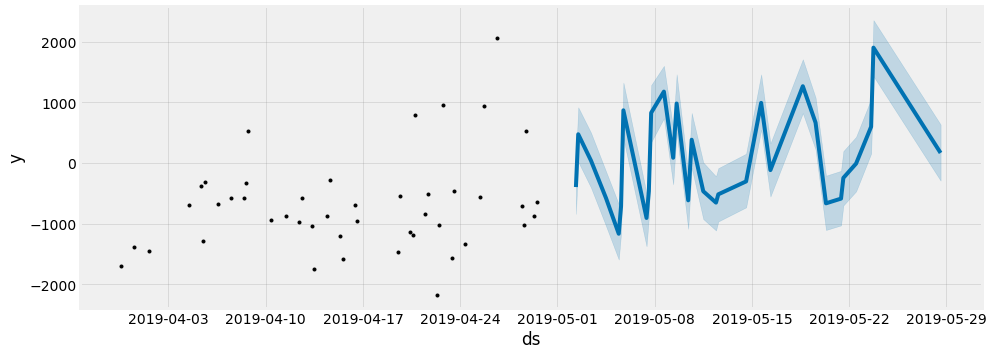

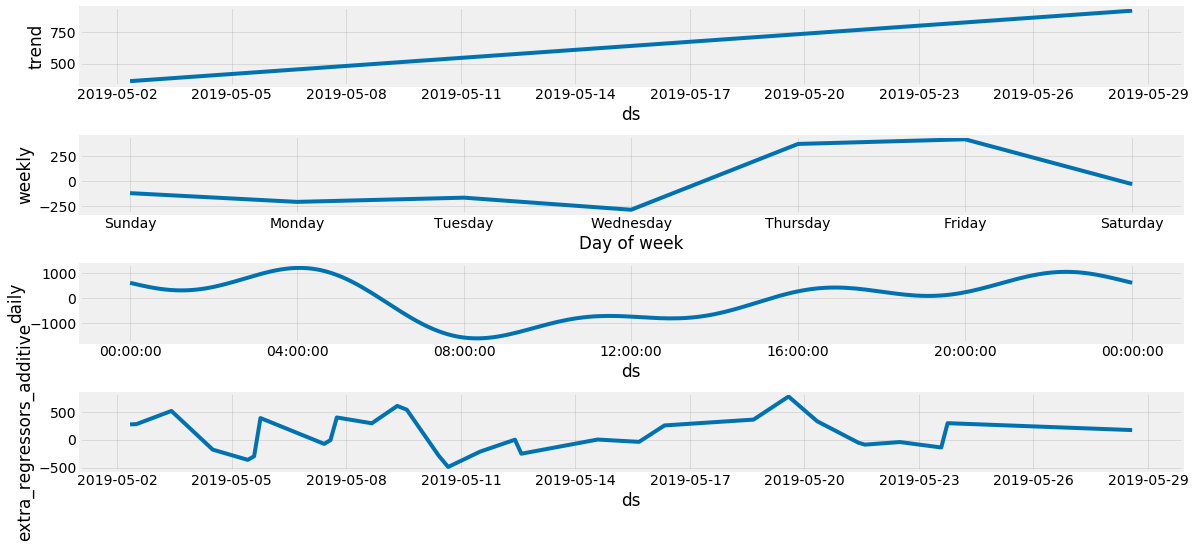

In [166]:

fig21 = pro_regressor.plot(forecast_data);
fig22 = pro_regressor.plot_components(forecast_data)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)